In [333]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

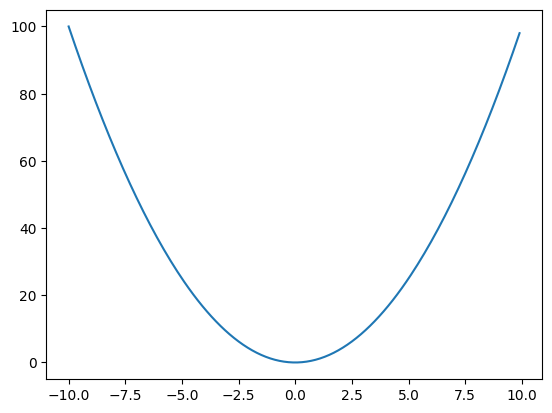

In [334]:
def f(x):
    return x**2

xs = np.arange(-10, 10, 0.1)
ys = f(xs)

plt.plot(xs, ys)
plt.show()

In [335]:
h = 0.0001
x = -3.0
(f(x+h) - f(x)) / h

-5.99990000001327

In [336]:
class Value: 

    def __init__(self, data, _children={}, _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        if isinstance(other, Value):
            other = other
        else:
            other = Value(other)

        out = Value(self.data + other.data, {self, other}, '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, Value):
            other = other
        else:
            other = Value(other)

        out = Value(self.data * other.data, {self, other}, '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, {self, }, 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

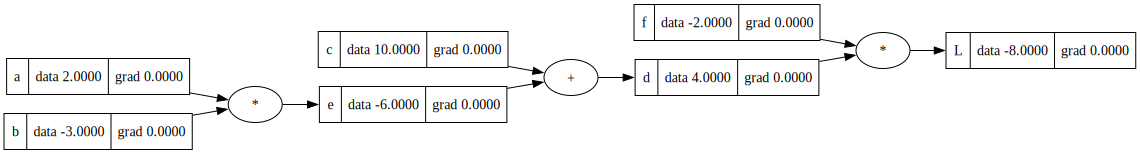

In [337]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(L)

In [338]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0



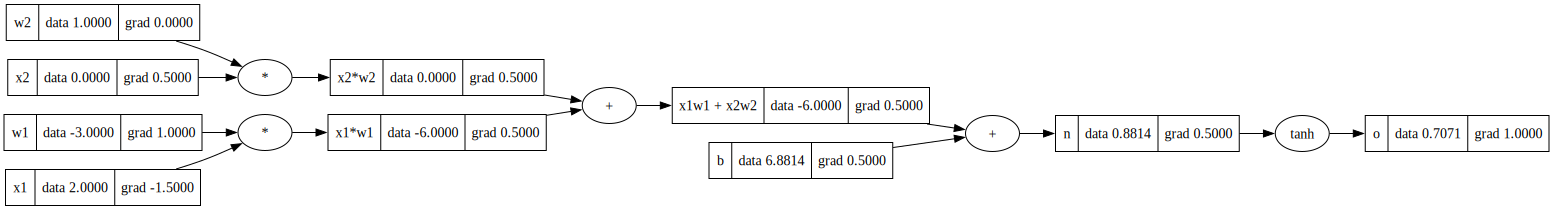

In [339]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
b = Value(6.881373587019543, label='b')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [340]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
b = torch.Tensor([6.881373587019543]).double(); b.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(x1.grad, x2.grad, w1.grad, w2.grad, b.grad)

0.7071066904050358
tensor([-1.5000], dtype=torch.float64) tensor([0.5000], dtype=torch.float64) tensor([1.0000], dtype=torch.float64) tensor([0.], dtype=torch.float64) tensor([0.5000], dtype=torch.float64)


In [341]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [342]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7187360172050435)

In [343]:
len(n.parameters())

41

In [344]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7187360172050435),
 Value(data=0.12875655975624317),
 Value(data=0.8081669900240815),
 Value(data=0.7064333843880638)]

In [345]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.708850020825024)

In [346]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.708850020825024)

In [347]:
loss.backward()

In [374]:
for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.001459130935955811
1 0.0014525616435480547
2 0.0014460472922735107
3 0.0014395872136476898
4 0.0014331807498442796
5 0.0014268272534853732
6 0.0014205260874363308
7 0.0014142766246056258
8 0.0014080782477492704
9 0.00140193034927975
10 0.0013958323310795048
11 0.0013897836043184188
12 0.0013837835892758295
13 0.001377831715166299
14 0.0013719274199695867
15 0.0013660701502642382
16 0.0013602593610651695
17 0.0013544945156646815
18 0.0013487750854771904
19 0.0013431005498873885


In [375]:
ypred

[Value(data=0.9839568360719826),
 Value(data=-0.9914483112077215),
 Value(data=-0.975075688227565),
 Value(data=0.980217059305133)]